# Summary: 

This notebook is for analyzing experiments for checking the quality of utility model learned using different methods (st, pca) on different sets of axes (for PCA) and on data with varying levels of low-rank-ness.

## TODO: log the dimension of the PCA-learned subspace

In [1]:
%load_ext autoreload
%autoreload 2

import itertools
import pickle
import re
import warnings
from collections import defaultdict
from dataclasses import asdict, dataclass
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import torch 

warnings.filterwarnings("ignore")

import sys
sys.path.append('..')

/home/yz685/anaconda3/envs/bope_pca/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
output_path = '/home/yz685/low_rank_BOPE/experiments/util_fit/'
rank_vals = [1,2,4,6,8]

In [ ]:
# data structure for extracting the results
# degrees of freedom: rank, method, type of axes, alpha
# want to plot: acc vs alpha for different types of axes

In [58]:
results = defaultdict(dict)

In [59]:

for rank in rank_vals:
    for method in ['pca', 'st']:
        d = torch.load(output_path + f'rank_{rank}_linear_{method}_acc.pt')
        results[rank][method] = pd.DataFrame(d[0])


In [60]:
results[4]['pca']

,pca_learned_rel,pca_learned_abs,pca_true_rel,pca_true_abs,pca_oracle_rel,pca_oracle_abs,learned_latent_dim
0,0.845,0.860,0.570,0.615,1.0,1.0,16
1,0.865,0.865,0.790,0.820,1.0,1.0,16
2,0.825,0.875,0.825,0.855,1.0,1.0,16
3,0.750,0.895,0.875,1.000,1.0,1.0,16


In [52]:
def plot_helper(rank):

    alphas = [0, 0.4, 0.6, 1.0]
    fig, axs = plt.subplots(1,2, figsize = (12,4))

    for col in ['pca_learned_rel', 'pca_true_rel', 'pca_oracle_rel']:
        axs[0].plot(alphas, results[rank]['pca'][col], '-o', label=col)

    axs[0].plot(alphas, results[rank]['st']['st_rel'], '--o', label = 'st_rel')

    axs[0].legend()
    axs[0].set_title(f'Utility model (pairwise data) test accuracy \n (Input dim = 5, Outcome dim = 20, Rank = {rank})')

    for col in ['pca_learned_abs', 'pca_true_abs', 'pca_oracle_abs']:
        axs[1].plot(alphas, results[rank]['pca'][col], '-o', label=col)

    axs[1].plot(alphas, results[rank]['st']['st_abs'], '--o', label = 'st_abs')

    axs[1].legend()
    axs[1].set_title(f'Utility model (absolute data) test accuracy \n (Input dim = 5, Outcome dim = 20, Rank = {rank})')

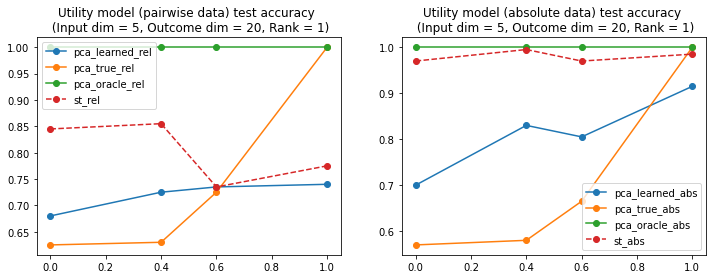

In [53]:
plot_helper(rank=1)

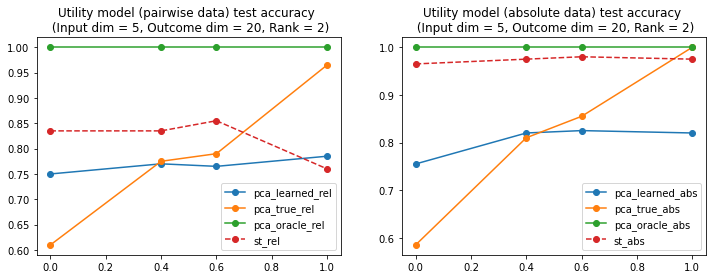

In [54]:
plot_helper(rank=2)

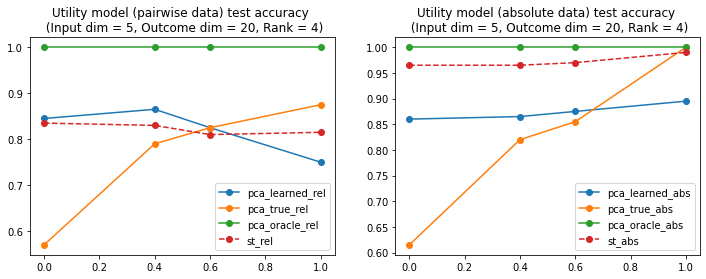

In [55]:
plot_helper(rank=4)


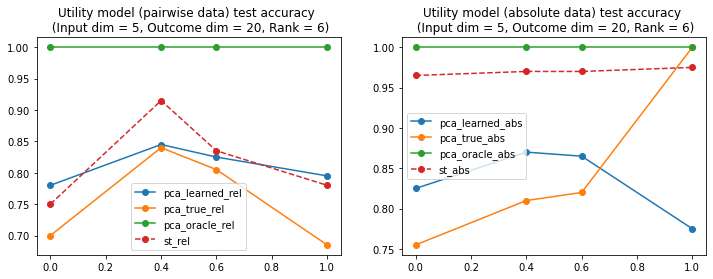

In [56]:
plot_helper(rank=6)


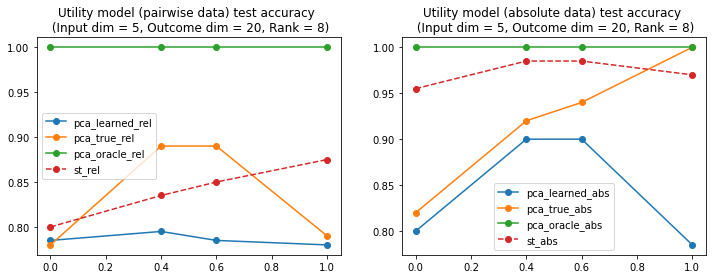

In [57]:
plot_helper(rank=8)
